In [ ]:
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import resnet50, ResNet50_Weights
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from PIL import Image

SEED = 1234

In [ ]:
# install skorch
!pip install skorch
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 6.3 MB/s eta 0:00:00


Exploratory Data Analysis
The file Folds.csv contains all image files' path and filename. It includes a 5-fold cross-validation strategy. I will read it into a dataframe and find each file's main type label(benign or malignant) and sub-type label.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Count and visualize the statistics of the dataset.¶
def get_subtype(x):
    x = x.split("/")[-1]
    x = x.split('-')[0]
    return x.split('_')[2]

pd.set_option('display.max_columns', 10)
fold_data = pd.read_csv("/content/drive/MyDrive/DL/breast/Folds.csv")
# Get the real path of file in kaggle
fold_data['filename'] = ("/content/drive/MyDrive/DL/breast/"+fold_data["filename"])
#Find the main type label and sub type label for each image
fold_data["main_type"] = fold_data["filename"].str.extract("(malignant|benign)")
fold_data["sub_type"] = fold_data["filename"].apply(lambda x:get_subtype(x))
fold_data

fold  mag    grp                                           filename  \
0         1  100  train  /content/drive/MyDrive/DL/breast/benign/SOB/ad...   
1         1  100  train  /content/drive/MyDrive/DL/breast/benign/SOB/ad...   
2         1  100  train  /content/drive/MyDrive/DL/breast/benign/SOB/ad...   
3         1  100  train  /content/drive/MyDrive/DL/breast/benign/SOB/ad...   
4         1  100  train  /content/drive/MyDrive/DL/breast/benign/SOB/ad...   
...     ...  ...    ...                                                ...   
39540     5  400   test  /content/drive/MyDrive/DL/breast/malignant/SOB...   
39541     5  400   test  /content/drive/MyDrive/DL/breast/malignant/SOB...   
39542     5  400   test  /content/drive/MyDrive/DL/breast/malignant/SOB...   
39543     5  400   test  /content/drive/MyDrive/DL/breast/malignant/SOB...   
39544     5  400   test  /content/drive/MyDrive/DL/breast/malignant/SOB...   

       main_type sub_type  
0         benign        A  
1         benign        A  
2         benign        A  
3         benign        A  
4         benign        A  
...          ...      ...  
39540  malignant       PC  
39541  malignant       PC  
39542  malignant       PC  
39543  malignant       PC  
39544  malignant       PC  

[39545 rows x 6 columns]

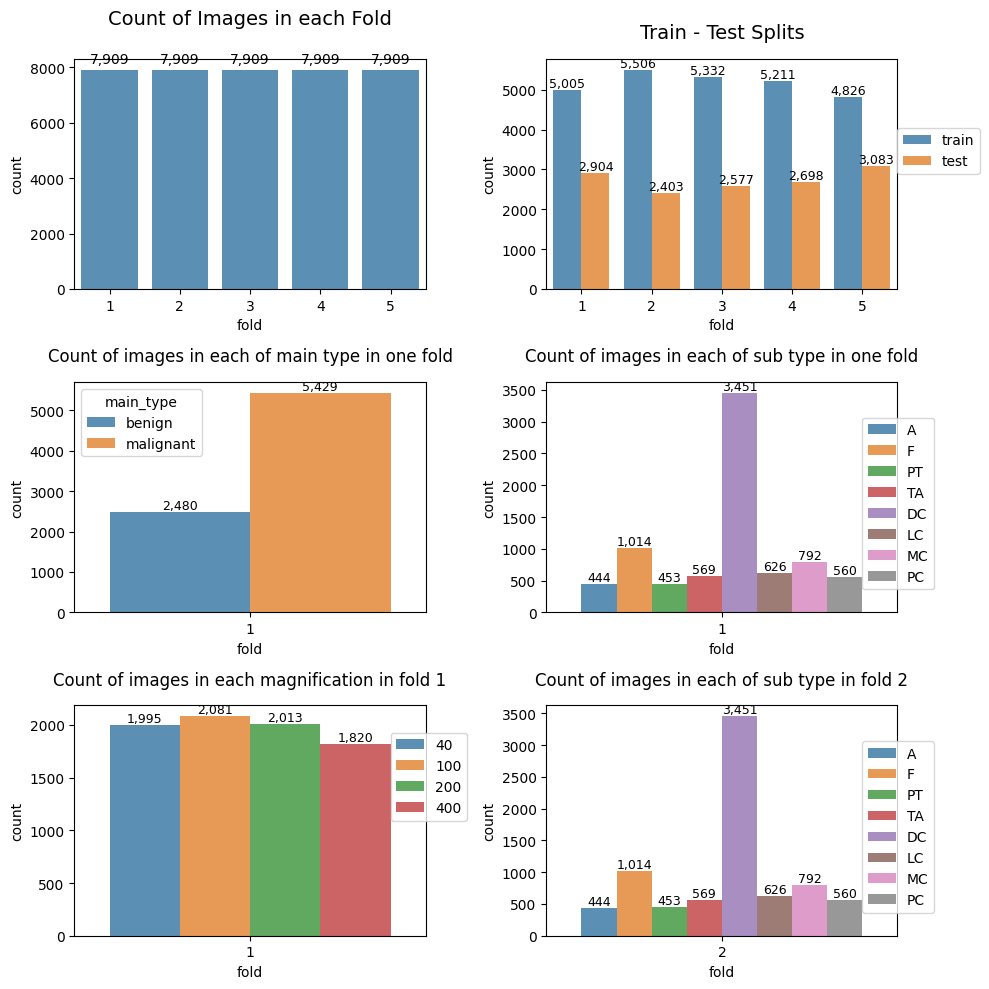

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), tight_layout=True)
# Plot image count in each fold
sb.countplot(data=fold_data, x="fold", color="C0", ax=ax[0][0], alpha=0.8)
bars = ax[0][0].containers[0]
ax[0][0].bar_label(bars, padding=3,
                labels=[f"{x:,.0f}" for x in bars.datavalues])

ax[0][0].set_title("Count of Images in each Fold", size=14, pad=25)

# Plot train-test split
sb.countplot(data=fold_data, x="fold", hue="grp", palette="tab10",
              ax=ax[0][1], alpha=0.8)
for bars in ax[0][1].containers:
    ax[0][1].bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)

ax[0][1].set_title("Train - Test Splits", size=14, pad=15)
ax[0][1].legend(loc=(1, 0.5));

# Plot image count in each main type
sb.countplot(data=fold_data[fold_data.fold==1], x="fold", hue="main_type", palette="tab10",
              ax=ax[1][0], alpha=0.8)
for bars in ax[1][0].containers:
    ax[1][0].bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)

ax[1][0].set_title("Count of images in each of main type in one fold", size=12, pad=15)


# Plot image count in each sub type
sb.countplot(data=fold_data[fold_data.fold==1], x="fold", hue="sub_type", palette="tab10",
              ax=ax[1][1], alpha=0.8)
for bars in ax[1][1].containers:
    ax[1][1].bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)

ax[1][1].set_title("Count of images in each of sub type in one fold", size=12, pad=15)
ax[1][1].legend(loc=(0.9, 0.1))

# Plot image count in each magnification
sb.countplot(data=fold_data[fold_data.fold==1], x="fold", hue="mag", palette="tab10",
              ax=ax[2][0], alpha=0.8)
for bars in ax[2][0].containers:
    ax[2][0].bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)

ax[2][0].set_title("Count of images in each magnification in fold 1", size=12, pad=15)
ax[2][0].legend(loc=(0.9, 0.5))

# Plot image count in each sub type
sb.countplot(data=fold_data[fold_data.fold==2], x="fold", hue="sub_type", palette="tab10",
              ax=ax[2][1], alpha=0.8)
for bars in ax[2][1].containers:
    ax[2][1].bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)

ax[2][1].set_title("Count of images in each of sub type in fold 2", size=12, pad=15)
ax[2][1].legend(loc=(0.9, 0.1))

In [ ]:
for i in range(1,6):
    print(f'fold {i}')
    print(pd.DataFrame({'num':fold_data[fold_data.fold==i].sub_type.value_counts()}).T)


fold 1
       DC     F   MC   LC   TA   PC   PT    A
num  3451  1014  792  626  569  560  453  444
fold 2
       DC     F   MC   LC   TA   PC   PT    A
num  3451  1014  792  626  569  560  453  444
fold 3
       DC     F   MC   LC   TA   PC   PT    A
num  3451  1014  792  626  569  560  453  444
fold 4
       DC     F   MC   LC   TA   PC   PT    A
num  3451  1014  792  626  569  560  453  444
fold 5
       DC     F   MC   LC   TA   PC   PT    A
num  3451  1014  792  626  569  560  453  444


In [ ]:
#Choose any fold dataset (eg. fold 1), split it into train set(90%) and test set(10%)
img_data = fold_data[fold_data.fold==1].drop(columns=['fold','grp'])
test = img_data.sample(frac=0.3,random_state=SEED)
train = img_data.drop(test.index)
train.reset_index(inplace=True)
train.drop(columns=['index'],inplace=True)
test.reset_index(inplace=True)
test.drop(columns=['index'],inplace=True)
train.shape,test.shape

((5536, 4), (2373, 4))

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train2 = le.fit_transform(train.main_type)
y_test2 = le.transform(test.main_type)
main_classname = list(le.classes_)

le1 = preprocessing.LabelEncoder()
y_train8 = le1.fit_transform(train.sub_type)
y_test8 = le1.transform(test.sub_type)
sub_classname = list(le1.classes_)


y_train8,y_test8

(array([0, 0, 0, ..., 5, 5, 5]), array([1, 1, 6, ..., 1, 1, 5]))

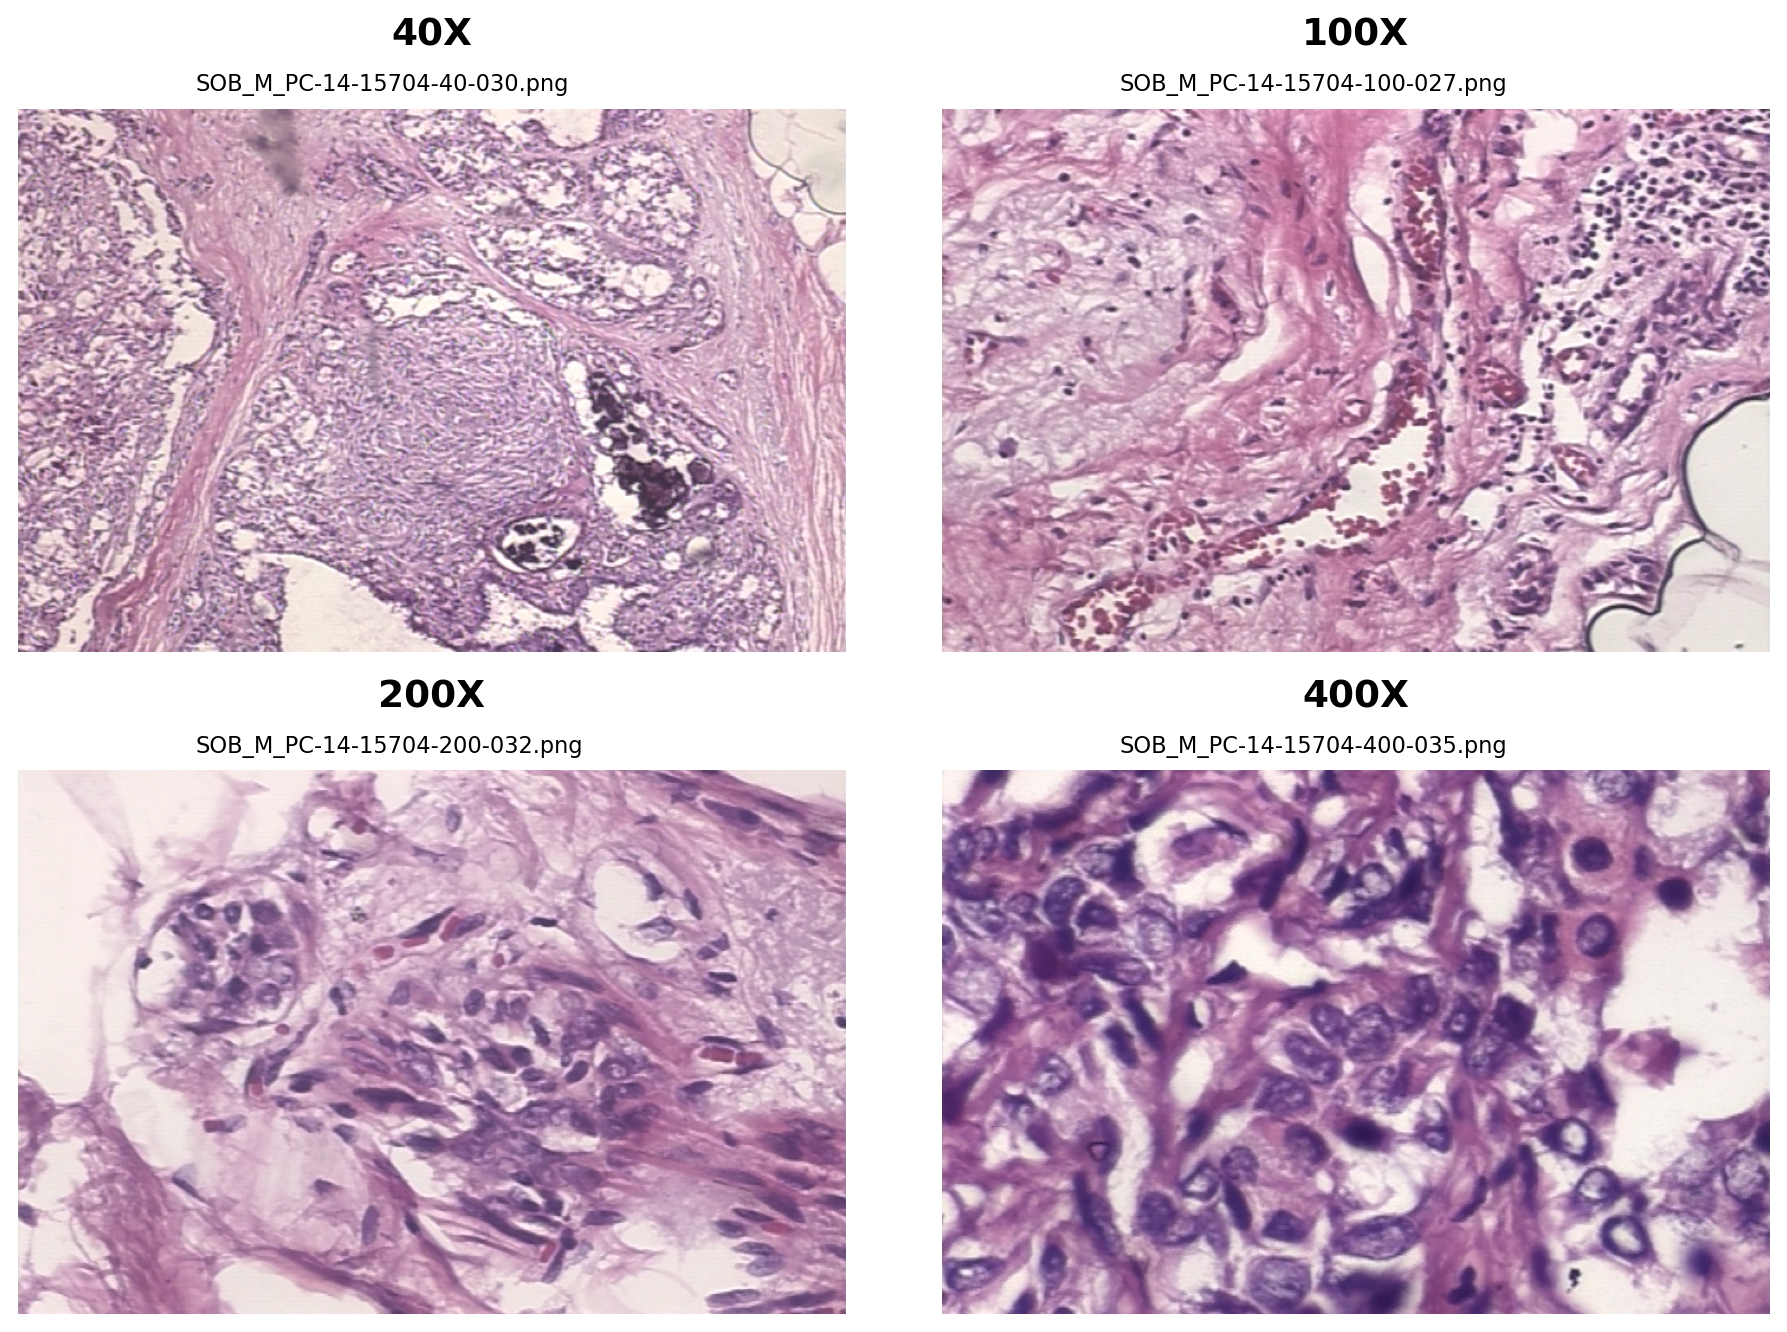

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7.5), dpi=180, tight_layout=True)
sample_images = train.groupby("mag", as_index=False).last()
for ax, row in zip(axes.flat, sample_images.itertuples()):
    img = Image.open(row.filename)
    ax.imshow(img)
    ax.set_title(f"{row.mag}X", size=15, pad=25, weight=600)
    ax.text(150, -15, row.filename.split("/")[-1], size=9)
    ax.axis("off")

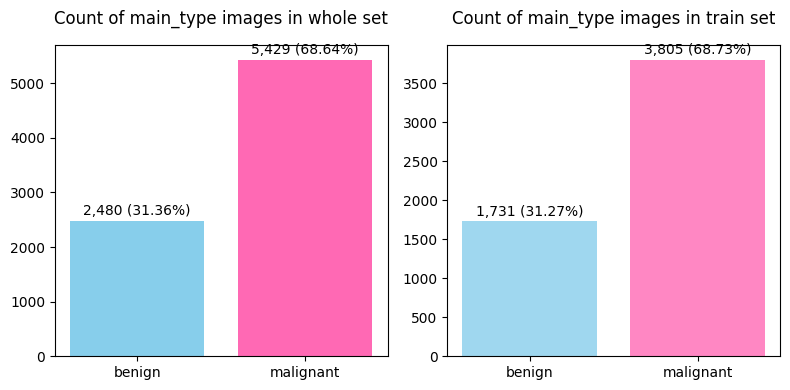

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4), tight_layout=True)

# Plot image count/prop in each main type
main_whole = img_data["main_type"].value_counts(ascending=True)
ax[0].bar(main_whole.index,main_whole,color=["skyblue", "hotpink"])
ax[0].bar_label(ax[0].containers[0], padding=2,
             labels=[f"{x:,} ({x/len(img_data):.2%})" for x in main_whole])
ax[0].set_title("Count of main_type images in whole set", size=12, pad=15)

# Plot image count/prop in each sub type
main_train = train["main_type"].value_counts(ascending=True)
ax[1].bar(main_train.index,main_train,color=["skyblue", "hotpink"], alpha=0.8)
ax[1].bar_label(ax[1].containers[0], padding=2,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in main_train])
ax[1].set_title("Count of main_type images in train set", size=12, pad=15)
plt.show()

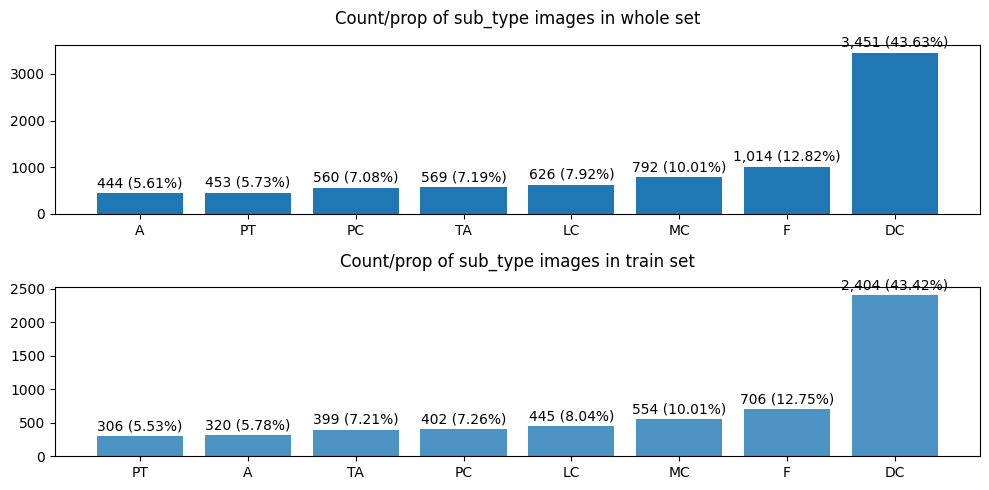

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 5), tight_layout=True)
# Plot image count/prop in each sub type for whole set
sub_whole = img_data["sub_type"].value_counts(ascending=True)
ax[0].bar(sub_whole.index,sub_whole)
ax[0].bar_label(ax[0].containers[0], padding=2,
             labels=[f"{x:,} ({x/len(img_data):.2%})" for x in sub_whole])
ax[0].set_title("Count/prop of sub_type images in whole set", size=12, pad=15)

# Plot image count/prop in each sub type for train set
sub_train = train["sub_type"].value_counts(ascending=True)
ax[1].bar(sub_train.index,sub_train, alpha=0.8)
ax[1].bar_label(ax[1].containers[0], padding=2,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in sub_train])
ax[1].set_title("Count/prop of sub_type images in train set", size=12, pad=15)
plt.show()

In [ ]:
from torch.utils.data import DataLoader
IMG_SIZE = 224
BATCH_SIZE = 32

# Define class to load image data
class load_data(torch.utils.data.Dataset):
    def __init__(self, X_df,y):
        self.X = X_df
        self.y = y
        self.T = transforms.Compose([
                    transforms.Resize(IMG_SIZE),
                    transforms.CenterCrop(IMG_SIZE),
                    transforms.ToTensor()])
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        row = self.X.iloc[index]
        img = Image.open(row['filename'])
        return self.T(img),self.y[index]


# load data batch by bathc
loader = DataLoader(
  load_data(train,y_train2),
  batch_size = 16)


def  img_mean_and_sd(loader):

    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])

        #comput first and second moment batch by batch
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    img_mean, img_std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
    return img_mean,img_std

#img_mean, img_std = img_mean_and_sd(loader)
#print("Images' mean and std: \n", img_mean, img_std)

#30%
img_mean=[0.7879, 0.6260, 0.7660]
img_std=[0.1249, 0.1765, 0.1083]
#10%
#img_mean=[0.7879, 0.6266, 0.7660]
#img_std=[0.1244, 0.1760, 0.1081]

In [ ]:
# Define class to load and transform image data
class load_data(torch.utils.data.Dataset):
    def __init__(self, X_df, y):
        self.X = X_df
        self.y = y
        self.T1 = transforms.Compose([
                    transforms.RandomResizedCrop(IMG_SIZE),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(img_mean,img_std)])
        self.T2 = transforms.Compose([
                    transforms.Resize(IMG_SIZE),
                    transforms.CenterCrop(IMG_SIZE),
                    transforms.ToTensor(),
                    transforms.Normalize(img_mean,img_std)])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        row = self.X.iloc[index]
        img = Image.open(row['filename'])
        if self.X.name == 'train': return self.T1(img),self.y[index]
        else: return self.T2(img),self.y[index]

# Prepare training and validation datasets for binary classfication
X_train, X_valid, y_train, y_valid = train_test_split(train, y_train2, test_size=0.25, random_state=SEED)
X_train.name = 'train'
X_valid.name = 'val'
test.name = 'test'
train.name = 'train'

# reset index
X_train.reset_index(inplace=True)
X_train.drop(columns=['index'],inplace=True)
X_valid.reset_index(inplace=True)
X_valid.drop(columns=['index'],inplace=True)

#All train images get through T1: resized, randomw size cropped, H flip, transformed to tensor and normalized.
#All validate and tesat images get through T2: center cropped, tranformed to tensor and normalized.
train_ds = load_data(X_train,y_train)
valid_ds = load_data(X_valid,y_valid)
test_ds = load_data(test,y_test2)

# Prepare training and validation datasets for 8-class classfication
X_train_8, X_valid_8, y_train_8, y_valid_8 = train_test_split(train, y_train8, test_size=0.1, random_state=SEED)
X_train_8.name = 'train'
X_valid_8.name = 'val'

# reset index
X_train_8.reset_index(inplace=True)
X_train_8.drop(columns=['index'],inplace=True)
X_valid_8.reset_index(inplace=True)
X_valid_8.drop(columns=['index'],inplace=True)

train_ds_8 = load_data(X_train_8,y_train_8)
valid_ds_8 = load_data(X_valid_8,y_valid_8)
test_ds_8 = load_data(test,y_test8)

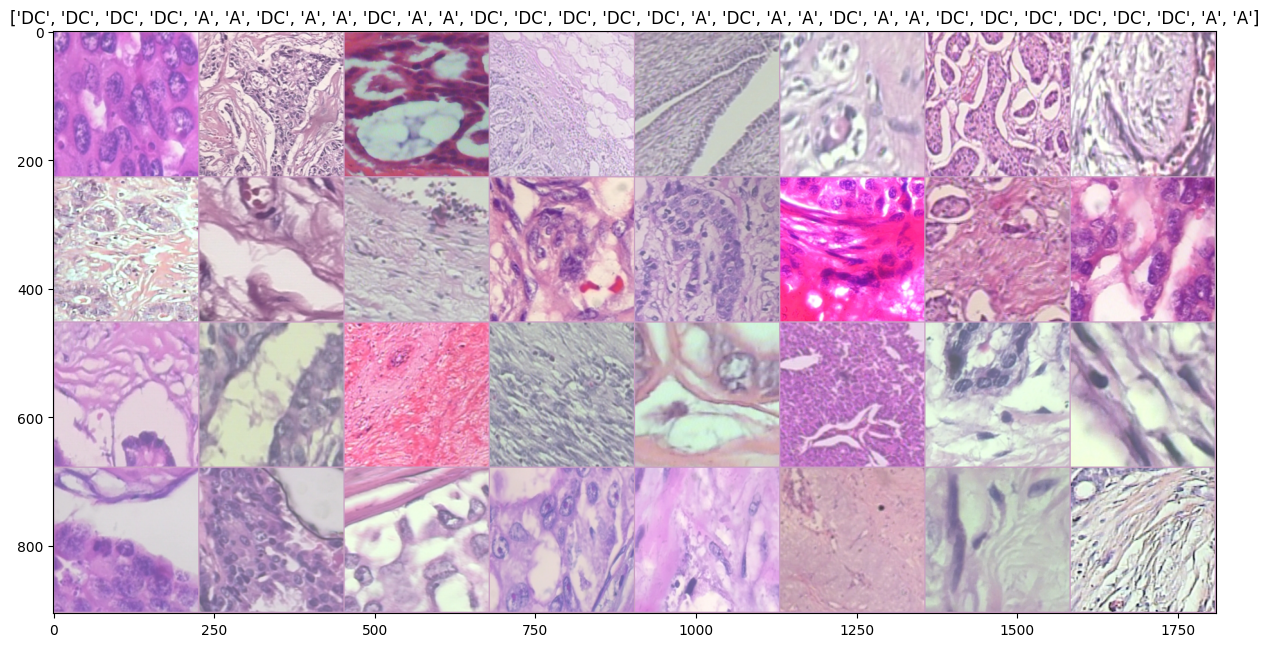

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(img_mean)
    std = np.array(img_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15,15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of training data
train_ds1 = DataLoader(load_data(X_train,y_train), batch_size=BATCH_SIZE, shuffle=True)
inputs, classes = next(iter(train_ds1))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[sub_classname[x] for x in classes])

In [ ]:
#Build resnet50 pretrained model
class PretrainedModel(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        num_ftrs = model.fc.in_features

        model.fc = nn.Sequential(
             nn.Linear(num_ftrs, 1000),
             nn.ReLU(),
             nn.Linear(1000, 128),
             nn.ReLU(),
             nn.Linear(128, output_features)
        )
        self.model = model


    def forward(self, x):
        return self.model(x)

DEVICE = 'cuda'


prenet = PretrainedModel(2)
print('Pretrained model ready!')


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 74.0MB/s]


Pretrained model ready!


In [ ]:
class HXVGG19(nn.Module):
  def __init__(self, num_classes=8):
    super().__init__()
    self.model = torchvision.models.vgg19(pretrained=True)
    in_features = self.model.classifier[-1].in_features
    self.model.classifier[-1] = nn.Linear(in_features, num_classes)

  def forward(self, x):
    return self.model(x)
a = HXVGG19(2)
model = torchvision.models.vgg19(pretrained=True)
model.classifier

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 95.5MB/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
#b = HXVGG19(8)

#Search the learning rate
#Use torch-lr-finder to search the learning rate range when using different optimizers.
optimizer = optim.SGD
LR suggestion: steepest gradient
Suggested LR: 1.66E-01

In [ ]:
from skorch.callbacks import LRScheduler,Checkpoint,TrainEndCheckpoint,Freezer
from torch.optim.lr_scheduler import CyclicLR

lrscheduler = LRScheduler(policy='StepLR', step_size=7, gamma=0.3)

freezer = Freezer(lambda x: not x.startswith('model.fc'))

In [ ]:
#Train model with Adam optimizer for 2 classes case
#1.Train the model with step LR scheduler and validate with predefined validation set

from skorch.callbacks import LRScheduler,Checkpoint,TrainEndCheckpoint,Freezer, ProgressBar, EarlyStopping, Checkpoint, EpochScoring
from torch.optim.lr_scheduler import CyclicLR

freezer = Freezer(lambda x: not x.startswith('model.fc'))
checkpoint = Checkpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam1_vgg19', monitor='valid_loss_best')
early_stopping = EarlyStopping(monitor='valid_loss', patience=3)


lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.5)
cp = Checkpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam1_vgg19')
train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam1_vgg19')
model_vgg19 = HXVGG19(2)

net = NeuralNetClassifier(
    model_vgg19,
    criterion=nn.CrossEntropyLoss,
    lr=0.0003,
    batch_size=32,
    max_epochs=30,
    #module__output_features=2,
    optimizer=optim.Adam,
    optimizer__weight_decay=1e-4,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds),
    callbacks=[lrscheduler,cp,train_end_cp, ProgressBar(), checkpoint, EpochScoring(scoring='accuracy', on_train=True)],
    #callbacks=[lrscheduler,cp,train_end_cp],
    #callbacks=[lrscheduler,cp,train_end_cp, ProgressBar(), checkpoint, early_stopping, EpochScoring(scoring='accuracy', on_train=True)],

    device = 'cuda'
    #device = 'cuda' if torch.cuda.is_available() else 'cpu'
)

_ = net.fit(train_ds,y=None)
print('Training complete!')

  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      lr        dur
-------  ----------  ------------  -----------  ------------  ----  ------  ---------
      1      0.7645        0.5217       0.8555        0.4174     +  0.0003  1254.8181


      2      0.8471        0.3799       0.8757        0.3315     +  0.0003  64.1222


      3      0.8789        0.3252       0.8960        0.2518     +  0.0003  63.8186


      4      0.8938        0.2706       0.8822        0.2908        0.0003  63.0375


      5      0.9070        0.2416       0.9017        0.2375     +  0.0003  61.6773


      6      0.9253        0.1887       0.9126        0.2057     +  0.0001  64.4186


      7      0.9246        0.1910       0.9234        0.1800     +  0.0001  63.1370


      8      0.9383        0.1641       0.9386        0.1567     +  0.0001  63.9892


      9      0.9444        0.1485       0.9335        0.1624        0.0001  64.6586


     10      0.9364        0.1620       0.9299        0.1864        0.0001  61.9363


     11      0.9494        0.1237       0.9400        0.1414     +  0.0001  61.9879


     12      0.9511        0.1158       0.9494        0.1387     +  0.0001  64.7161


     13      0.9518        0.1189       0.9451        0.1345     +  0.0001  64.5318


     14      0.9562        0.1078       0.9530        0.1190     +  0.0001  64.5287


     15      0.9593        0.1041       0.9422        0.1508        0.0001  64.5149


     16      0.9684        0.0848       0.9530        0.1376        0.0000  61.8178


     17      0.9663        0.0821       0.9552        0.1192        0.0000  61.6064


     18      0.9723        0.0759       0.9523        0.1325        0.0000  61.5296


     19      0.9668        0.0813       0.9617        0.0939     +  0.0000  61.4816


     20      0.9716        0.0734       0.9581        0.1086        0.0000  63.9261


     21      0.9740        0.0685       0.9610        0.0936     +  0.0000  61.4523


     22      0.9778        0.0634       0.9610        0.0970        0.0000  63.8847


     23      0.9745        0.0633       0.9624        0.1083        0.0000  61.7429


     24      0.9781        0.0577       0.9639        0.1052        0.0000  61.7447


     25      0.9759        0.0648       0.9653        0.0969        0.0000  61.7107


     26      0.9805        0.0541       0.9646        0.0895     +  0.0000  61.8834


     27      0.9798        0.0534       0.9646        0.0943        0.0000  64.2157


     28      0.9786        0.0558       0.9639        0.0951        0.0000  61.8674


     29      0.9781        0.0532       0.9660        0.0950        0.0000  61.5016


     30      0.9831        0.0461       0.9668        0.0896        0.0000  61.9259


Training complete!


In [ ]:
# #smaller lr, train on validation set

# lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.5)
# cp = Checkpoint(dirname='/content/drive/MyDrive/breast/BreaKHis_record/Adam1_vgg19')
# train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/breast/BreaKHis_record/Adam1_vgg19')
# model_vgg19 = HXVGG19(2)

# net1 = NeuralNetClassifier(
#     model_vgg19,
#     criterion=nn.CrossEntropyLoss,
#     lr=0.0001,
#     batch_size=32,
#     max_epochs=10,
#     optimizer=optim.Adam,
#     optimizer__weight_decay=1e-4,
#     iterator_train__shuffle=True,
#     iterator_train__num_workers=2,
#     iterator_valid__shuffle=False,
#     iterator_valid__num_workers=2,
#     train_split=predefined_split(valid_ds),
#     callbacks=[lrscheduler,cp,train_end_cp],
#     device = 'cuda'
#     #device = torch.device("mps")
# )

# net1.initialize()
# net1.load_params(f_params='/content/drive/MyDrive/breast/BreaKHis_record/Adam_vgg19/params.pt')
# _ = net1.fit(load_data(train,y_train2),y=None)


In [ ]:
# #smaller lr and larger batch size
# from skorch.callbacks import LoadInitState
# load_state = LoadInitState(cp)
# lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.3)
# cp = Checkpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam2')
# train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam2')
# net1 = NeuralNetClassifier(
#     PretrainedModel(2),
#     criterion=nn.CrossEntropyLoss,
#     lr=0.00001,
#     batch_size=64,
#     max_epochs=20,
#     optimizer=optim.Adam,
#     optimizer__weight_decay=1e-4,
#     iterator_train__shuffle=True,
#     iterator_train__num_workers=2,
#     iterator_valid__shuffle=False,
#     iterator_valid__num_workers=2,
#     train_split=predefined_split(test_ds),
#     callbacks=[lrscheduler,cp,train_end_cp,load_state],
#     #device = 'cuda'
#     device = torch.device("mps")
# )

# net1.initialize()
# net1.load_params(f_params='/content/drive/MyDrive/breast/BreakHis_record/Adam1/params.pt')
# _ = net1.fit(load_data(train,y_train2),y=None)

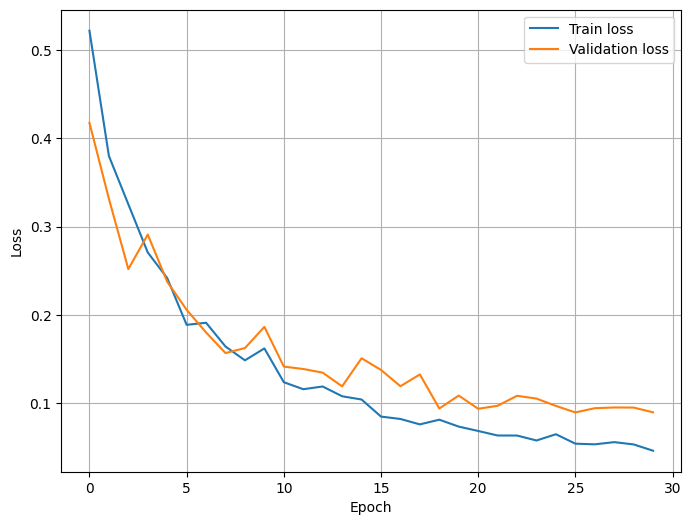

In [ ]:
# plot the train and validation loss curve
val_loss=[]
train_loss=[]

#net.initialize()
#net.load_params(f_params='/content/drive/MyDrive/breast/BreaKHis_record/Adam/train_end_params.pt',
#                f_history='/content/drive/MyDrive/breast/BreaKHis_record/Adam/train_end_history.json')


for i in range(30):
    val_loss.append(net.history[i]['valid_loss'])
    train_loss.append(net.history[i]['train_loss'])

plt.figure(figsize=(8,6))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

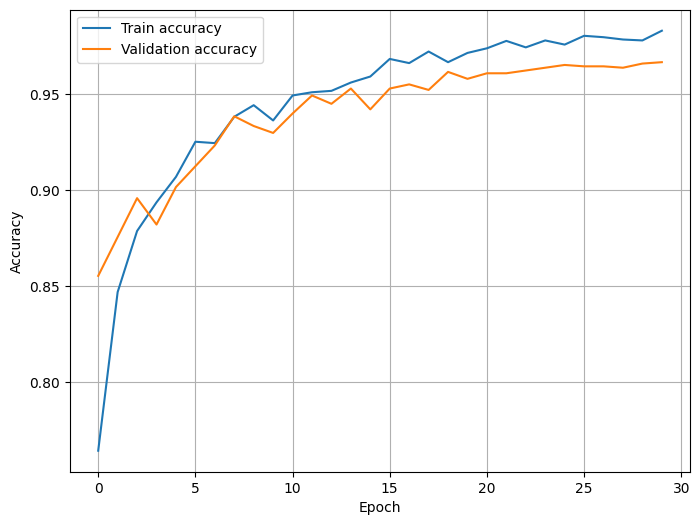

In [ ]:
val_acc=[]
train_acc=[]

for i in range(30):
    val_acc.append(net.history[i]['valid_acc'])
    train_acc.append(net.history[i]['accuracy'])

plt.figure(figsize=(8,6))
plt.plot(train_acc, label='Train accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()



In [ ]:
# install skorch
# !pip install skorch
# from skorch import NeuralNetClassifier
# from skorch.helper import predefined_split
# from skorch.callbacks import LRScheduler,Checkpoint,TrainEndCheckpoint,Freezer
# from torch.optim.lr_scheduler import CyclicLR

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
# model_vgg19 = HXVGG19(8)

# net1 = NeuralNetClassifier(
#     model_vgg19,
#     criterion=nn.CrossEntropyLoss,
#     lr=0.0003,
#     batch_size=32,
#     max_epochs=20,
#     optimizer=optim.Adam,
#     optimizer__weight_decay=1e-4,
#     iterator_train__shuffle=True,
#     iterator_train__num_workers=2,
#     iterator_valid__shuffle=False,
#     iterator_valid__num_workers=2,
#     train_split=predefined_split(valid_ds),
#     callbacks=[lrscheduler,cp,train_end_cp],
#     device = 'cuda'
# )

# net1.initialize()
# net1.load_params(f_params='/content/drive/MyDrive/breast/BreakHis_record/Adam_vgg19/params.pt')


y_pred = net.predict(test_ds)
accuracy2 = accuracy_score(y_test2, y_pred)
print(f'The test accuracy for binary classification:   {round(accuracy2*100,2)}%')

The test accuracy for binary classification:   96.59%


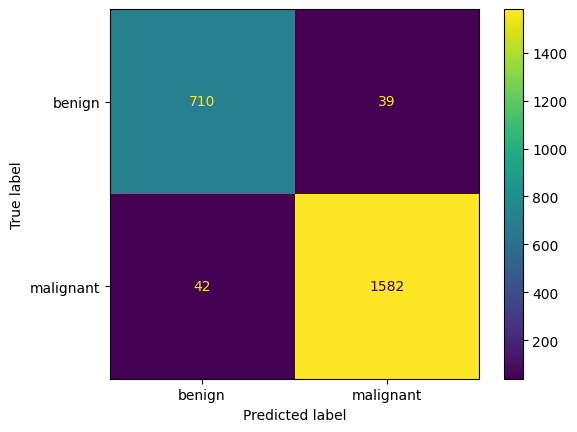

              precision    recall  f1-score   support

      benign     0.9441    0.9479    0.9460       749
   malignant     0.9759    0.9741    0.9750      1624

    accuracy                         0.9659      2373
   macro avg     0.9600    0.9610    0.9605      2373
weighted avg     0.9659    0.9659    0.9659      2373

Accuracy for benign: 0.9659 
Accuracy for malignant: 0.9659 


In [ ]:
#Prediction of 2-class classifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=main_classname)
disp.plot()
plt.show()
print(classification_report(y_test2, y_pred, target_names=main_classname, digits=4))
per_class_accuracies = {}
for idx, cls in enumerate(main_classname):
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    true_positives = cm[idx, idx]
    per_class_accuracies[cls] = round((true_positives + true_negatives) / np.sum(cm),4)
    print(f'Accuracy for {cls}: {per_class_accuracies[cls]} ')

In [ ]:
#Train model with Adam optimizer for 8 classes case
#Train the model with step LR scheduler and validate with predefined validation set

from skorch.callbacks import LRScheduler,Checkpoint,TrainEndCheckpoint,Freezer, ProgressBar, EarlyStopping, Checkpoint, EpochScoring
from torch.optim.lr_scheduler import CyclicLR

lrscheduler = LRScheduler(policy='StepLR', step_size=7, gamma=0.3)

freezer = Freezer(lambda x: not x.startswith('model.fc'))
checkpoint = Checkpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam8_1-vgg19', monitor='valid_loss_best')
early_stopping = EarlyStopping(monitor='valid_loss', patience=3)


lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.5)
cp = Checkpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam8_1-vgg19')
train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam8_1-vgg19')

model_vgg19 = HXVGG19(8)

net = NeuralNetClassifier(
    model_vgg19,
    criterion=nn.CrossEntropyLoss,
    lr=0.0003,
    batch_size=32,
    max_epochs=50,
    optimizer=optim.Adam,
    optimizer__weight_decay=1e-4,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds_8),
    callbacks=[lrscheduler,cp,train_end_cp, ProgressBar(), checkpoint, EpochScoring(scoring='accuracy', on_train=True)],
    #callbacks=[lrscheduler,cp,train_end_cp],
        #callbacks=[lrscheduler,cp,train_end_cp, ProgressBar(), checkpoint, early_stopping, EpochScoring(scoring='accuracy', on_train=True)],
    device = 'cuda'
)

_ = net.fit(train_ds_8,y=None)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
                                                                  

  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  ----------  ------------  -----------  ------------  ----  ------  -------
      1      0.4745        1.6414       0.4819        1.4753     +  0.0003  61.9835


      2      0.5313        1.3991       0.4928        1.5600        0.0003  63.9436


      3      0.5494        1.3105       0.5108        1.3176     +  0.0003  61.9805


      4      0.5672        1.2532       0.5054        1.4123        0.0003  63.3508


      5      0.5765        1.2198       0.5379        1.3219        0.0003  62.5773


      6      0.6096        1.0700       0.5830        1.1108     +  0.0001  62.2956


      7      0.6307        0.9986       0.6282        1.0361     +  0.0001  64.3682


      8      0.6527        0.9260       0.6173        0.9910     +  0.0001  65.5435


      9      0.6652        0.8845       0.6697        0.8841     +  0.0001  64.7761


     10      0.6815        0.8450       0.7022        0.8017     +  0.0001  64.2814


     11      0.7260        0.7173       0.7238        0.7388     +  0.0001  64.9801


     12      0.7381        0.6735       0.7310        0.6806     +  0.0001  64.6869


     13      0.7363        0.6685       0.7491        0.6303     +  0.0001  64.8255


     14      0.7545        0.6301       0.7527        0.5991     +  0.0001  64.7648


     15      0.7688        0.6103       0.7834        0.5890     +  0.0001  63.6609


     16      0.7912        0.5235       0.7599        0.5830     +  0.0000  64.0866


     17      0.7959        0.4974       0.7816        0.5550     +  0.0000  64.9114


     18      0.7916        0.5058       0.7744        0.5644        0.0000  64.5462


     19      0.8077        0.4783       0.7996        0.5134     +  0.0000  62.5529


     20      0.8193        0.4535       0.8051        0.5305        0.0000  64.0956


     21      0.8382        0.4175       0.7888        0.5162        0.0000  62.4606


     22      0.8414        0.4062       0.7924        0.5025     +  0.0000  62.1641


     23      0.8456        0.4002       0.7996        0.4920     +  0.0000  64.8413


     24      0.8454        0.3939       0.8051        0.4976        0.0000  65.2980


     25      0.8511        0.3869       0.8105        0.4878     +  0.0000  62.2754


     26      0.8553        0.3662       0.8213        0.4552     +  0.0000  65.6285


     27      0.8563        0.3543       0.8195        0.4518     +  0.0000  64.8397


     28      0.8657        0.3452       0.8105        0.4732        0.0000  65.3141


     29      0.8645        0.3456       0.8159        0.4555        0.0000  62.4486


     30      0.8647        0.3420       0.8051        0.4814        0.0000  60.6692


     31      0.8762        0.3182       0.8231        0.4563        0.0000  62.0442


     32      0.8671        0.3276       0.8141        0.4636        0.0000  62.2219


     33      0.8719        0.3186       0.8159        0.4540        0.0000  62.2657


     34      0.8749        0.3109       0.8285        0.4602        0.0000  61.9019


     35      0.8792        0.3117       0.8159        0.4586        0.0000  62.3087


     36      0.8806        0.3045       0.8213        0.4557        0.0000  62.2300


     37      0.8848        0.2996       0.8249        0.4497     +  0.0000  62.5902


     38      0.8749        0.3190       0.8303        0.4468     +  0.0000  64.7700


     39      0.8842        0.3013       0.8303        0.4613        0.0000  64.4809


     40      0.8816        0.3038       0.8267        0.4512        0.0000  61.8122


     41      0.8874        0.2944       0.8249        0.4590        0.0000  61.5401


     42      0.8836        0.2948       0.8249        0.4489        0.0000  62.2900


     43      0.8838        0.2958       0.8231        0.4491        0.0000  62.2412


     44      0.8806        0.3059       0.8303        0.4535        0.0000  62.0384


     45      0.8868        0.2898       0.8249        0.4528        0.0000  62.4182


     46      0.8864        0.2862       0.8321        0.4557        0.0000  62.6474


     47      0.8890        0.2945       0.8339        0.4542        0.0000  62.4642


     48      0.8848        0.3020       0.8231        0.4592        0.0000  62.2013


     49      0.8826        0.2921       0.8303        0.4476        0.0000  62.2925


     50      0.8808        0.2871       0.8249        0.4468        0.0000  62.5116


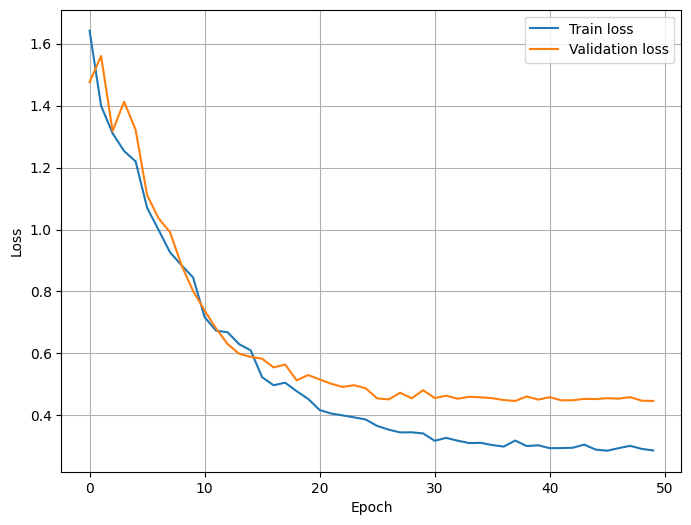

In [ ]:
#plot the train and validation loss curve
val_loss=[]
train_loss=[]
# net.initialize()
# net.load_params(f_params='/content/drive/MyDrive/breast/BreakHis_record/Adam8-vgg19/train_end_params.pt',
#                 f_history='/content/drive/MyDrive/breast/BreakHis_record/Adam8-vgg19/train_end_history.json')
for i in range(50):
    val_loss.append(net.history[i]['valid_loss'])
    train_loss.append(net.history[i]['train_loss'])

plt.figure(figsize=(8,6))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

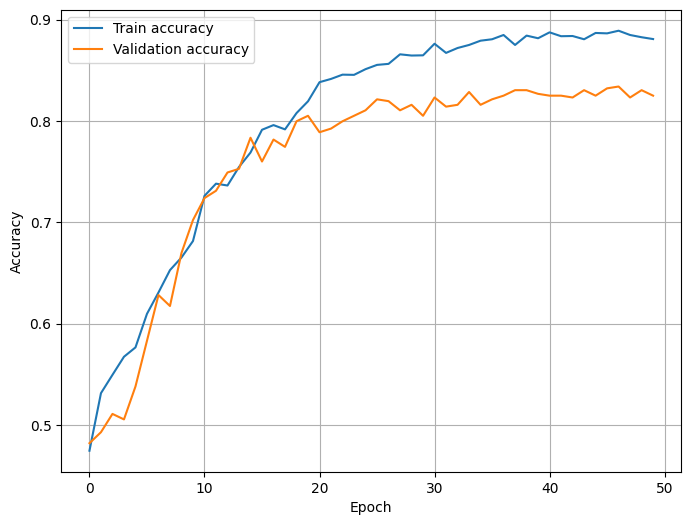

In [ ]:
val_acc=[]
train_acc=[]

for i in range(50):
    val_acc.append(net.history[i]['valid_acc'])
    train_acc.append(net.history[i]['accuracy'])

plt.figure(figsize=(8,6))
plt.plot(train_acc, label='Train accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()



In [ ]:
# #Prediction of 8-class classifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.5)
# cp = Checkpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam8-vgg19')
# train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam8-vgg19')


# model_vgg19 = HXVGG19(8)

# net1 = NeuralNetClassifier(
#     model_vgg19,
#     criterion=nn.CrossEntropyLoss,
#     lr=0.0003,
#     batch_size=32,
#     max_epochs=40,
#     optimizer=optim.Adam,
#     optimizer__weight_decay=1e-4,
#     iterator_train__shuffle=True,
#     iterator_train__num_workers=2,
#     iterator_valid__shuffle=False,
#     iterator_valid__num_workers=2,
#     train_split=predefined_split(valid_ds),
#     callbacks=[lrscheduler,cp,train_end_cp],
#     device = 'cuda'
# )

# net1.initialize()
# net1.load_params(f_params='/content/drive/MyDrive/breast/BreakHis_record/Adam8-vgg19/params.pt')

y_pred8 = net.predict(test_ds_8)
accuracy8 = accuracy_score(y_test8, y_pred8)
print(f'The test accuracy for 8-class classification: {round(accuracy8*100,2)}%')

The test accuracy for 8-class classification: 85.67%


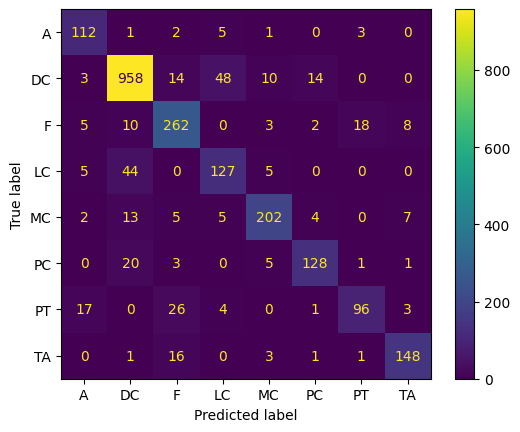

              precision    recall  f1-score   support

           A     0.7778    0.9032    0.8358       124
          DC     0.9150    0.9150    0.9150      1047
           F     0.7988    0.8506    0.8239       308
          LC     0.6720    0.7017    0.6865       181
          MC     0.8821    0.8487    0.8651       238
          PC     0.8533    0.8101    0.8312       158
          PT     0.8067    0.6531    0.7218       147
          TA     0.8862    0.8706    0.8783       170

    accuracy                         0.8567      2373
   macro avg     0.8240    0.8191    0.8197      2373
weighted avg     0.8580    0.8567    0.8564      2373

Accuracy for A: 98.15% 
Accuracy for DC: 92.5% 
Accuracy for F: 95.28% 
Accuracy for LC: 95.11% 
Accuracy for MC: 97.35% 
Accuracy for PC: 97.81% 
Accuracy for PT: 96.88% 
Accuracy for TA: 98.27% 


In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test8, y_pred8)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sub_classname)
disp.plot()
plt.show()
print(classification_report(y_test8, y_pred8, target_names=sub_classname, digits=4))
per_class_accuracies = {}
for idx, cls in enumerate(sub_classname):
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    true_positives = cm[idx, idx]
    per_class_accuracies[cls] = round((true_positives + true_negatives) / np.sum(cm)*100,2)
    print(f'Accuracy for {cls}: {per_class_accuracies[cls]}% ')

In [ ]:
#Prepare the balanced data Over-sampling using SMOTE
#Perform over-sampling using SMOTE to increase minority class size to be same as majority class 'DC'.

from imblearn.over_sampling import SMOTEN
print(f'The train set shape before over-sampling: {train.shape}')
smote = SMOTEN(sampling_strategy='auto',random_state=SEED)
#sample_strategy = {0: 2000, 1: 2000, 2: 2000, 3: 2000, 4: 2000}
#smote = SMOTEN(sampling_strategy=sample_strategy, random_state=SEED)
Xtrain_sm,ytrain_sm8 = smote.fit_resample(train,y_train8)
#ytrain_sm2 = le.transform(Xtrain_sm.main_type)
print(f"After over sampling, the train set shape : {Xtrain_sm.shape}")
print(f"Sample count in each class: {Xtrain_sm.sub_type.value_counts()}")

The train set shape before over-sampling: (5536, 4)
After over sampling, the train set shape : (19232, 4)
Sample count in each class: A     2404
F     2404
PT    2404
TA    2404
DC    2404
LC    2404
MC    2404
PC    2404
Name: sub_type, dtype: int64


In [ ]:
#Load and transform the image data Apply RandomHorizontalFlip() and transforms.RandomVerticalFlip() during loading data to
#reduce duplicates when add more images for minority class.

# Define class to load and transform image data
torch.manual_seed(SEED)
class load_data(torch.utils.data.Dataset):
    def __init__(self, X_df, y):
        self.X = X_df
        self.y = y
        self.T1 = transforms.Compose([
                    transforms.Resize((IMG_SIZE,IMG_SIZE)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(90),
                    transforms.RandomRotation(180),
                    transforms.ToTensor(),
                    transforms.Normalize(img_mean,img_std)])
        self.T2 = transforms.Compose([
                    transforms.Resize((IMG_SIZE,IMG_SIZE)),
                    transforms.ToTensor(),
                    transforms.Normalize(img_mean,img_std)])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        row = self.X.iloc[index]
        img = Image.open(row['filename'])
        if self.X.name == 'train': return self.T1(img),self.y[index]
        else: return self.T2(img),self.y[index]

# # Prepare training and validation datasets for binary classfication
# X_train, X_valid, y_train, y_valid = train_test_split(Xtrain_sm, ytrain_sm2, test_size=0.25, random_state=SEED)
# X_train.name = 'train'
# X_valid.name = 'val'
# test.name = 'test'
# train.name = 'train'

# # reset index
# X_train.reset_index(inplace=True)
# X_train.drop(columns=['index'],inplace=True)
# X_valid.reset_index(inplace=True)
# X_valid.drop(columns=['index'],inplace=True)

# train_ds_sm = load_data(X_train,y_train)
# valid_ds_sm = load_data(X_valid,y_valid)
# test_ds = load_data(test,y_test2)

# Prepare training and validation datasets for 8-class classfication, 10% for test
X_train_8, X_valid_8, y_train_8, y_valid_8 = train_test_split(Xtrain_sm, ytrain_sm8, test_size=0.25, random_state=SEED)
X_train_8.name = 'train'
X_valid_8.name = 'val'
test.name = 'test'

# reset index
X_train_8.reset_index(inplace=True)
X_train_8.drop(columns=['index'],inplace=True)
X_valid_8.reset_index(inplace=True)
X_valid_8.drop(columns=['index'],inplace=True)

train_ds_sm8 = load_data(X_train_8,y_train_8)
valid_ds_sm8 = load_data(X_valid_8,y_valid_8)
test_ds_8 = load_data(test,y_test8)
print(f"After over sampling, the train set shape : {X_train_8.shape}")
print(f"After over sampling, the validation set shape : {X_valid_8.shape}")

After over sampling, the train set shape : (14424, 4)
After over sampling, the validation set shape : (4808, 4)


In [ ]:
from skorch.callbacks import LRScheduler,Checkpoint,TrainEndCheckpoint,Freezer
from torch.optim.lr_scheduler import CyclicLR

lrscheduler = LRScheduler(policy='StepLR', step_size=7, gamma=0.3)

freezer = Freezer(lambda x: not x.startswith('model.fc'))

In [ ]:
#Train model with Adam optimizer for 8 classes case Train the model with step LR scheduler and validate with predefined validation set
from skorch.callbacks import LRScheduler,Checkpoint,TrainEndCheckpoint,Freezer, ProgressBar, EarlyStopping, Checkpoint, EpochScoring
from torch.optim.lr_scheduler import CyclicLR

#freezer = Freezer(lambda x: not x.startswith('model.fc'))
checkpoint = Checkpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam8-1_sm8-vgg19', monitor='valid_loss_best')
#early_stopping = EarlyStopping(monitor='valid_loss', patience=3)


lrscheduler = LRScheduler(policy='StepLR', step_size=10, gamma=0.5)
cp = Checkpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam8-1_sm8-vgg19')
train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam8-1_sm8-vgg19')

model_vgg19 = HXVGG19(8)

net = NeuralNetClassifier(
    model_vgg19,
    criterion=nn.CrossEntropyLoss,
    lr=0.0003,
    batch_size=32,
    max_epochs=50,
    optimizer=optim.Adam,
    optimizer__weight_decay=1e-4,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds_sm8),
    #callbacks=[lrscheduler,cp,train_end_cp],
    callbacks=[lrscheduler,cp,train_end_cp, ProgressBar(), checkpoint, EpochScoring(scoring='accuracy', on_train=True)],
    device = 'cuda'
)

_ = net.fit(train_ds_sm8,y=None)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
                                                                  

  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ----------  ------------  -----------  ------------  ----  ------  --------
      1      0.5930        1.1143       0.6737        0.7741     +  0.0003  209.1029


      2      0.8179        0.5954       0.8139        0.6869     +  0.0003  211.3103


      3      0.8502        0.5131       0.8663        0.5467     +  0.0003  211.3308


      4      0.8622        0.4612       0.8463        0.4759     +  0.0003  211.2043


      5      0.8658        0.4536       0.8798        0.3876     +  0.0003  212.0592


      6      0.8816        0.3969       0.8933        0.3602     +  0.0003  212.9881


      7      0.8812        0.3900       0.8180        0.5509        0.0003  212.9865


      8      0.8809        0.3896       0.8740        0.3744        0.0003  211.1977


      9      0.9018        0.3104       0.9089        0.2941     +  0.0003  208.8273


     10      0.9018        0.3098       0.9181        0.2623     +  0.0003  210.7110


     11      0.9223        0.2400       0.9230        0.2349     +  0.0001  211.3651


     12      0.9259        0.2249       0.9185        0.2383        0.0001  213.8197


     13      0.9282        0.2156       0.9251        0.2125     +  0.0001  221.4765


     14      0.9303        0.2062       0.9289        0.2078     +  0.0001  223.9444


     15      0.9314        0.1992       0.9297        0.2298        0.0001  223.8146


     16      0.9334        0.1991       0.9370        0.1902     +  0.0001  222.2322


     17      0.9366        0.1865       0.9318        0.1976        0.0001  222.0785


     18      0.9393        0.1777       0.9301        0.2072        0.0001  220.6412


     19      0.9396        0.1762       0.9420        0.1856     +  0.0001  220.2258


     20      0.9418        0.1707       0.9222        0.2485        0.0001  223.4371


     21      0.9532        0.1313       0.9497        0.1572     +  0.0001  221.5576


     22      0.9584        0.1177       0.9399        0.1699        0.0001  223.5321


     23      0.9588        0.1140       0.9486        0.1493     +  0.0001  219.9233


     24      0.9608        0.1090       0.9490        0.1582        0.0001  222.0362


     25      0.9610        0.1085       0.9547        0.1408     +  0.0001  219.6056


     26      0.9631        0.1052       0.9515        0.1563        0.0001  222.9869


     27      0.9631        0.1003       0.9557        0.1405     +  0.0001  222.2082


     28      0.9638        0.0950       0.9601        0.1244     +  0.0001  224.2621


     29      0.9664        0.0952       0.9447        0.1811        0.0001  223.6774


     30      0.9679        0.0889       0.9547        0.1429        0.0001  221.8136


     31      0.9739        0.0695       0.9567        0.1293        0.0000  213.2964


     32      0.9770        0.0611       0.9640        0.1172     +  0.0000  214.0773


     33      0.9783        0.0571       0.9621        0.1270        0.0000  209.6278


     34      0.9771        0.0572       0.9646        0.1159     +  0.0000  207.5461


     35      0.9778        0.0568       0.9617        0.1268        0.0000  209.7950


     36      0.9800        0.0561       0.9615        0.1286        0.0000  209.2904


     37      0.9794        0.0535       0.9599        0.1378        0.0000  209.1263


     38      0.9805        0.0524       0.9651        0.1211        0.0000  210.4604


     39      0.9795        0.0494       0.9632        0.1379        0.0000  209.9694


     40      0.9807        0.0498       0.9655        0.1303        0.0000  208.6893


     41      0.9862        0.0362       0.9663        0.1230        0.0000  211.2502


     42      0.9858        0.0355       0.9684        0.1179        0.0000  212.1385


     43      0.9867        0.0333       0.9665        0.1319        0.0000  223.8703


     44      0.9859        0.0357       0.9684        0.1210        0.0000  223.3687


     45      0.9865        0.0317       0.9667        0.1298        0.0000  221.8300


     46      0.9859        0.0313       0.9698        0.1252        0.0000  222.4400


     47      0.9878        0.0306       0.9690        0.1272        0.0000  221.6915


     48      0.9884        0.0279       0.9667        0.1334        0.0000  221.0637


     49      0.9866        0.0315       0.9661        0.1309        0.0000  220.5371


     50      0.9866        0.0311       0.9669        0.1321        0.0000  221.3935


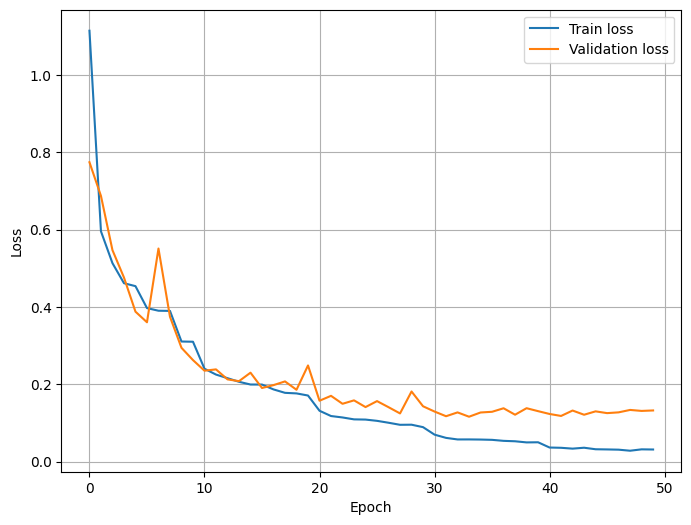

In [ ]:
val_loss=[]
train_loss=[]

#net.initialize()
#net.load_params(f_params='/content/drive/MyDrive/DL/breast/BreaKHis_record/Adam_sm8/train_end_params.pt',
#                f_history='/content/drive/MyDrive/DL/breast/BreaKHis_record/Adam_sm8/train_end_history.json')

for i in range(50):
    val_loss.append(net.history[i]['valid_loss'])
    train_loss.append(net.history[i]['train_loss'])

plt.figure(figsize=(8,6))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

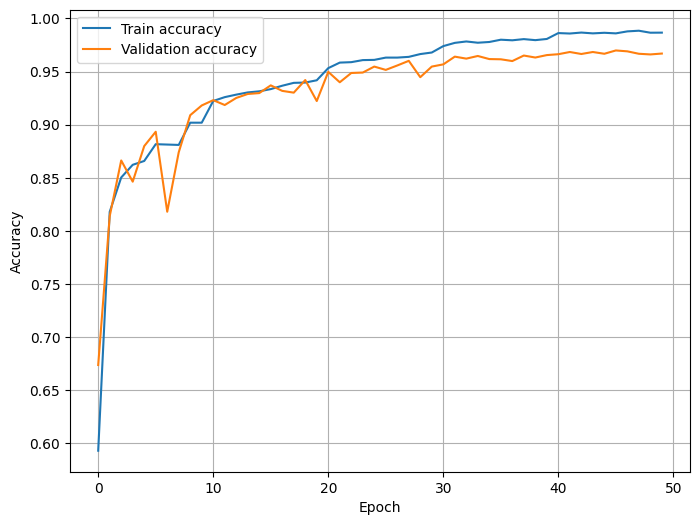

In [ ]:
val_acc=[]
train_acc=[]

for i in range(50):
    val_acc.append(net.history[i]['valid_acc'])
    train_acc.append(net.history[i]['accuracy'])

plt.figure(figsize=(8,6))
plt.plot(train_acc, label='Train accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()



In [ ]:
#Prediction of 5-class classifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


# lrscheduler = LRScheduler(policy='StepLR', step_size=7, gamma=0.5)
# cp = Checkpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam8_sm8-vgg19')
# train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/breast/BreakHis_record/Adam8_sm8-vgg19')

# model_vgg19 = HXVGG19(8)

# net = NeuralNetClassifier(
#     model_vgg19,
#     criterion=nn.CrossEntropyLoss,
#     lr=0.0003,
#     batch_size=32,
#     max_epochs=20,
#     optimizer=optim.Adam,
#     optimizer__weight_decay=1e-4,
#     iterator_train__shuffle=True,
#     iterator_train__num_workers=2,
#     iterator_valid__shuffle=False,
#     iterator_valid__num_workers=2,
#     train_split=predefined_split(valid_ds_sm8),
#     callbacks=[lrscheduler,cp,train_end_cp],
#     device = 'cuda'
# )


# net.initialize()
# net.load_params(f_params='/content/drive/MyDrive/breast/BreakHis_record/Adam8_sm8-vgg19/train_end_params.pt')


y_pred8 = net.predict(test_ds_8)
accuracy8 = accuracy_score(y_test8, y_pred8)
print(f'The test accuracy for 8-class classification: {round(accuracy8*100,2)}%')

The test accuracy for 8-class classification: 88.33%


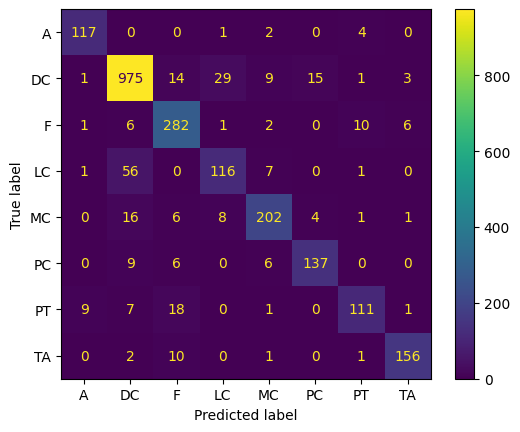

              precision    recall  f1-score   support

           A     0.9070    0.9435    0.9249       124
          DC     0.9104    0.9312    0.9207      1047
           F     0.8393    0.9156    0.8758       308
          LC     0.7484    0.6409    0.6905       181
          MC     0.8783    0.8487    0.8632       238
          PC     0.8782    0.8671    0.8726       158
          PT     0.8605    0.7551    0.8043       147
          TA     0.9341    0.9176    0.9258       170

    accuracy                         0.8833      2373
   macro avg     0.8695    0.8525    0.8597      2373
weighted avg     0.8819    0.8833    0.8817      2373

Accuracy for A: 99.2% 
Accuracy for DC: 92.92% 
Accuracy for F: 96.63% 
Accuracy for LC: 95.62% 
Accuracy for MC: 97.3% 
Accuracy for PC: 98.31% 
Accuracy for PT: 97.72% 
Accuracy for TA: 98.95% 
Confusion Matrix
[[117   0   0   1   2   0   4   0]
 [  1 975  14  29   9  15   1   3]
 [  1   6 282   1   2   0  10   6]
 [  1  56   0 116   7   0   1  

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report

confusion_mat = confusion_matrix(y_test8, y_pred8)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=sub_classname)
disp.plot()
plt.show()
sub_classname_str = [str(x) for x in sub_classname]
print(classification_report(y_test8, y_pred8, target_names=sub_classname_str, digits=4))
per_class_accuracies = {}
for idx, cls in enumerate(sub_classname):
    true_negatives = np.sum(np.delete(np.delete(confusion_mat, idx, axis=0), idx, axis=1))
    true_positives = confusion_mat[idx, idx]
    per_class_accuracies[cls] = round((true_positives + true_negatives) / np.sum(confusion_mat)*100,2)
    print(f'Accuracy for {cls}: {per_class_accuracies[cls]}% ')
print("Confusion Matrix")
print(confusion_mat)